Jumlah data sebelum menghapus missing value (nilai 99): 984
Jumlah data setelah menghapus missing value: 772
Jumlah data yang dihapus: 212

Data setelah menghapus nilai 99:
    stay_online  neglect_chores  excitement  relationships  life_complaint  \
14          4.0             3.0         5.0            5.0             5.0   
15          2.0             1.0         2.0            3.0             0.0   
16          3.0             3.0         2.0            2.0             3.0   
18          3.0             2.0         3.0            1.0             3.0   
19          2.0             2.0         2.0            1.0             1.0   

    school_work  email_socialmedia  job_performance  defensive_secretive  \
14          0.0                5.0              0.0                  5.0   
15          0.0                3.0              0.0                  1.0   
16          3.0                3.0              3.0                  3.0   
18          4.0                4.0              3.0   

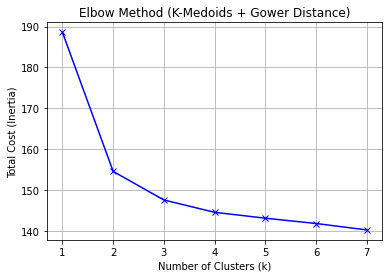


=== Silhouette Score  ===
📊 Silhouette Score untuk k=2: 0.27744579315185547
📊 Silhouette Score untuk k=3: 0.12025979906320572
📊 Silhouette Score untuk k=4: 0.09455399960279465
📊 Silhouette Score untuk k=5: 0.09887789934873581
📊 Silhouette Score untuk k=6: 0.0897986963391304
📊 Silhouette Score untuk k=7: 0.04258589819073677


In [1]:
# === Data desciption, Elbow method, dan Silhouette Score k = 3 ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gower
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score



# === Step 1: Load dataset ===
data = pd.read_csv('IAT_data_imported.csv')

print("Jumlah data sebelum menghapus missing value (nilai 99):", len(data))


# === Step 2: Select only the 20 IAT variables ===
original_vars = [
    'stay_online', 'neglect_chores', 'excitement', 'relationships', 'life_complaint',
    'school_work', 'email_socialmedia', 'job_performance', 'defensive_secretive',
    'disturbing_thoughts', 'online_anticipation', 'life_no_internet', 'act_annoyed',
    'late_night_logins', 'feel_preoccupied', 'online_glued', 'time_cutdown',
    'hide_online', 'more_online_time', 'feel_depressed'
]
data_subset = data[original_vars]


# === Step 3: Remove rows containing value 99 (treated as missing) ===
data_clean = data_subset.replace(99, np.nan).dropna()

print("Jumlah data setelah menghapus missing value:", len(data_clean))
print("Jumlah data yang dihapus:", len(data) - len(data_clean))
print("\nData setelah menghapus nilai 99:")
print(data_clean.head())


# === Step 4: Hitung Gower Distance Matrix ===
print("\nMenghitung Gower Distance Matrix...")
distance_matrix = gower.gower_matrix(data_clean)


# === Step 5: Elbow Method (Total Cost / Inertia) ===
print("\n=== Elbow Method (Within-Cluster Total Dissimilarity) ===")

wctd = []
K_elbow = range(1, 8)

for k in K_elbow:
    kmed = KMedoids(n_clusters=k, metric='precomputed', random_state=42)
    kmed.fit(distance_matrix)
    wctd.append(kmed.inertia_)
    


# === Plot Elbow Curve ===
plt.figure(figsize=(6, 4))
plt.plot(K_elbow, wctd, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Total Cost (Inertia)')
plt.title('Elbow Method (K-Medoids + Gower Distance)')
plt.grid(True)
plt.show()


# === Step 6: Silhouette Score for k = 2 to 7 ===
print("\n=== Silhouette Score  ===")

silhouette_scores = []

for k in range(2, 8):
    kmed = KMedoids(n_clusters=k, metric='precomputed', random_state=42)
    kmed.fit(distance_matrix)
    labels = kmed.labels_
    sil = silhouette_score(distance_matrix, labels, metric='precomputed')
    silhouette_scores.append(sil)
    print(f"📊 Silhouette Score untuk k={k}: {round(sil, 7)}")




=== Jumlah Subjek per Cluster ===
Cluster 1: 360 subjek
Cluster 2: 237 subjek
Cluster 3: 175 subjek

Membuat horizontal stacked bar chart nilai ordinal per variabel untuk setiap cluster...


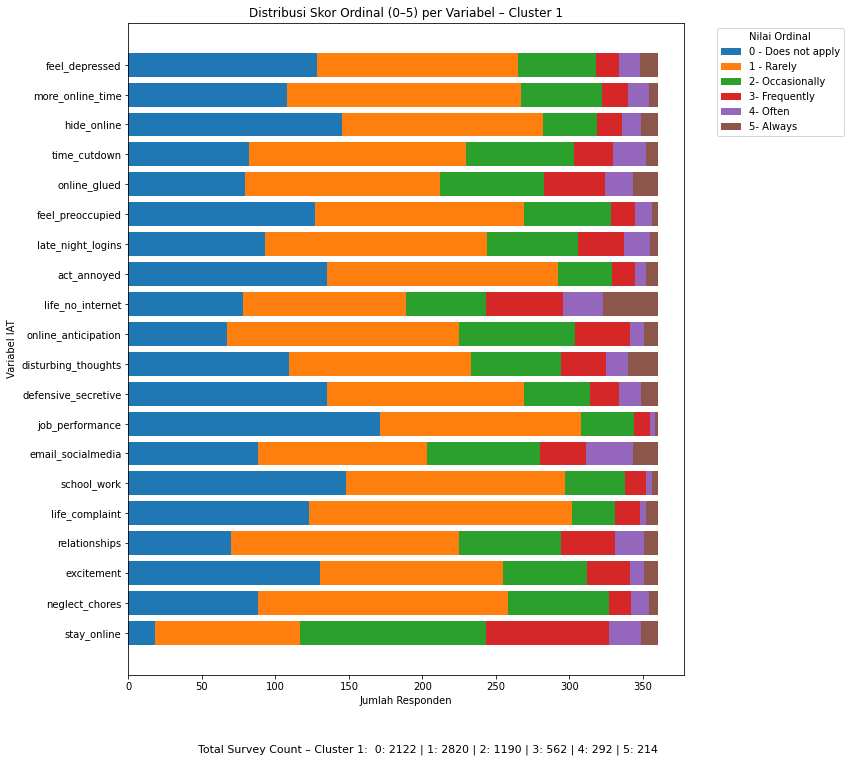

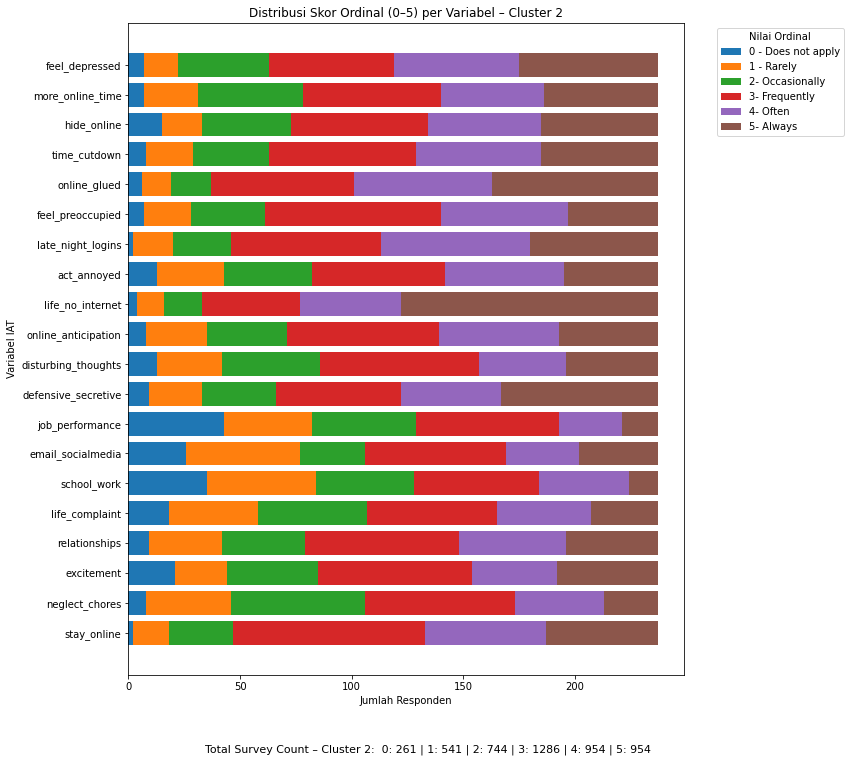

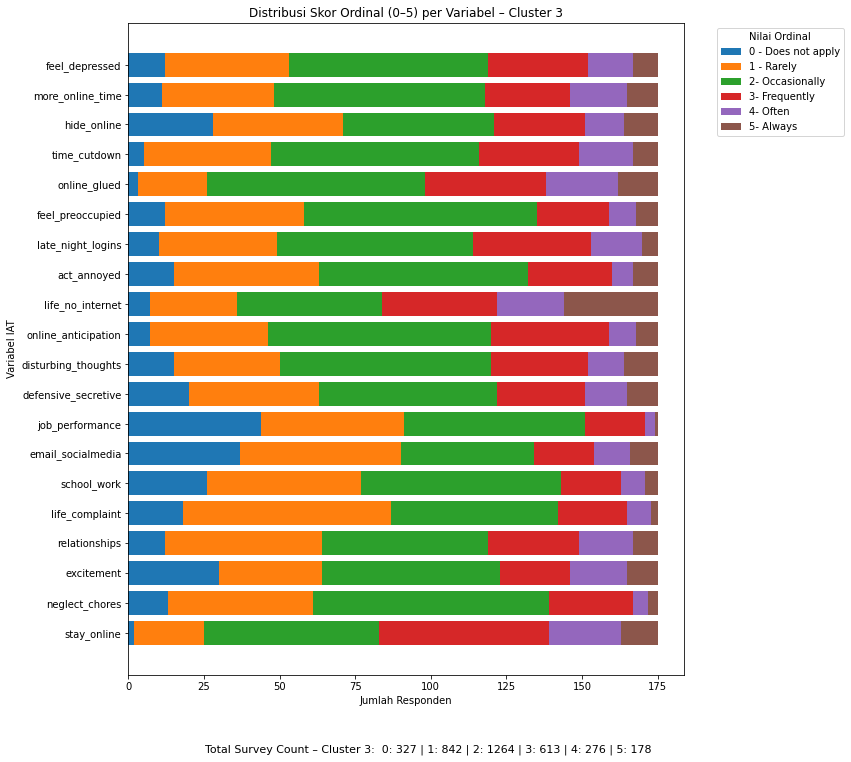

In [3]:
# === Stacked Bar Chart K =3===


# === Step 7: Final K-Medoids Clustering (choose your k) ===
optimal_k = 3  # ganti jika perlu
kmed_final = KMedoids(n_clusters=optimal_k, metric='precomputed', random_state=42)
kmed_final.fit(distance_matrix)

# === Count how many subjects are in each cluster ===
cluster_counts = pd.Series(kmed_final.labels_ + 1).value_counts().sort_index()

print("\n=== Jumlah Subjek per Cluster ===")
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} subjek")

#========================================================================================
# === Step 8: Horizontal Stacked Bar Chart per Cluster ===
print("\nMembuat horizontal stacked bar chart nilai ordinal per variabel untuk setiap cluster...")

labels_final = kmed_final.labels_ + 1
clustered_data = data_clean.copy()
clustered_data['Cluster'] = labels_final

ordinal_levels = [0, 1, 2, 3, 4, 5]

custom_labels = {
    0: "0 - Does not apply",
    1: "1 - Rarely",
    2: "2- Occasionally",
    3: "3- Frequently",
    4: "4- Often",
    5: "5- Always"
}

for c in range(1, optimal_k + 1):
    df_cluster = clustered_data[clustered_data['Cluster'] == c]

    freq = pd.DataFrame(index=original_vars, columns=ordinal_levels)

    for var in original_vars:
        vc = df_cluster[var].value_counts()
        for level in ordinal_levels:
            freq.loc[var, level] = vc.get(level, 0)

    freq = freq.fillna(0).astype(int)

    ordinal_totals = freq.sum(axis=0)
    summary_text = " | ".join([f"{level}: {ordinal_totals[level]}" for level in ordinal_levels])

    plt.figure(figsize=(12, 10))
    left = np.zeros(len(original_vars))

    for level in ordinal_levels:
        plt.barh(
            original_vars,
            freq[level],
            left=left,
            label=custom_labels[level]
        )
        left += freq[level]

    plt.title(f"Distribusi Skor Ordinal (0–5) per Variabel – Cluster {c}")
    plt.xlabel("Jumlah Responden")
    plt.ylabel("Variabel IAT")
    plt.legend(title="Nilai Ordinal", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.figtext(
        0.5, -0.05,
        f"Total Survey Count – Cluster {c}:  {summary_text}",
        ha="center", fontsize=11
    )

    plt.tight_layout()
    plt.show()

#=================================================================================



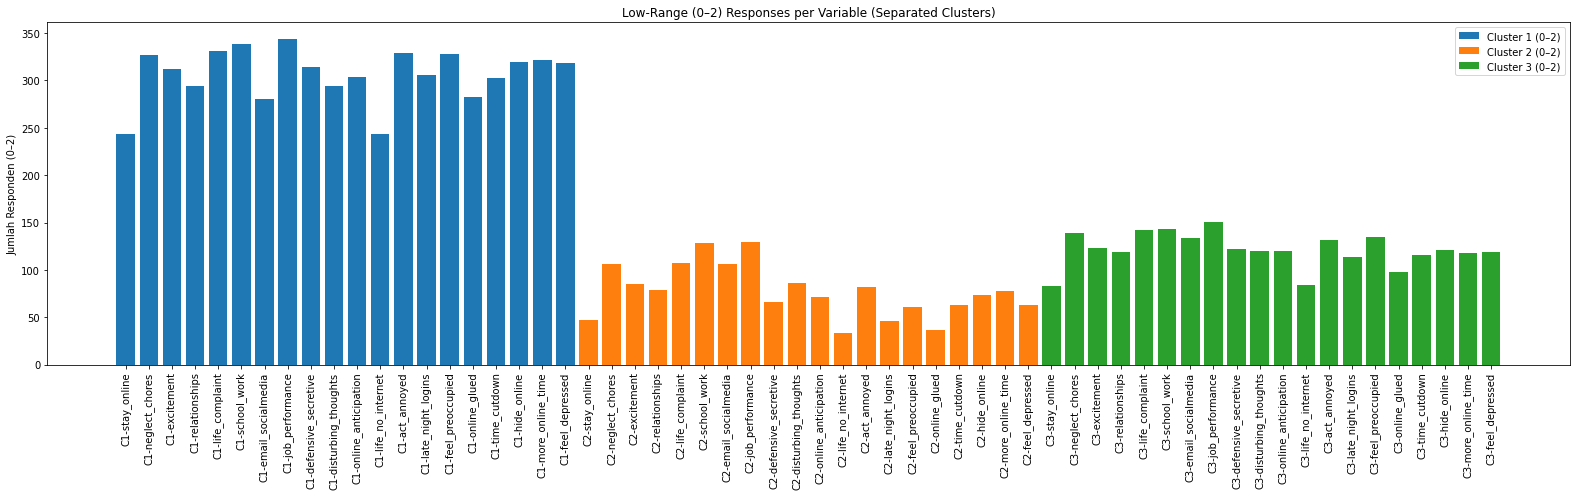

In [4]:
#=================================================================================
# === Pemisahan berdasarkan nilai kelompok ordinal terkecil (0-2) ===

# Count low-range (0,1,2) for each variable per cluster
low_cluster1 = []
low_cluster2 = []
low_cluster3 = []

for var in original_vars:
    low_cluster1.append(clustered_data[clustered_data["Cluster"] == 1][var].isin([0, 1, 2]).sum())
    low_cluster2.append(clustered_data[clustered_data["Cluster"] == 2][var].isin([0, 1, 2]).sum())
    low_cluster3.append(clustered_data[clustered_data["Cluster"] == 3][var].isin([0, 1, 2]).sum())

# X positions: 40 total bars → 20 cluster 1, then 20 cluster 2
x1 = np.arange(20)
x2 = np.arange(20, 40)
x3 = np.arange(40, 60)

plt.figure(figsize=(22, 7))

# Plot cluster 1 bars
plt.bar(x1, low_cluster1, label="Cluster 1 (0–2)")

# Plot cluster 2 bars shifted to the right
plt.bar(x2, low_cluster2, label="Cluster 2 (0–2)")

# Plot cluster 3 bars shifted to the right
plt.bar(x3, low_cluster3, label="Cluster 3 (0–2)")


# X-axis labels: combine C1 + C2 labels
combined_labels = [f"C1-{var}" for var in original_vars] + [f"C2-{var}" for var in original_vars] + [f"C3-{var}" for var in original_vars]

plt.xticks(np.arange(60), combined_labels, rotation=90)

plt.ylabel("Jumlah Responden (0–2)")
plt.title("Low-Range (0–2) Responses per Variable (Separated Clusters)")
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
#=================================================================================
# === Combined Table: Low-Range (0–2) Responses per Variable and Cluster ===

df_low_combined = pd.DataFrame({
    "IAT Variable": original_vars,
    "Cluster 1 (0–2)": low_cluster1,
    "Cluster 2 (0–2)": low_cluster2,
    "Cluster 3 (0–2)": low_cluster3
})

print("\n=== Low-Range (0–2) Responses per IAT Variable and Cluster ===")
print(df_low_combined)



=== Low-Range (0–2) Responses per IAT Variable and Cluster ===
           IAT Variable  Cluster 1 (0–2)  Cluster 2 (0–2)  Cluster 3 (0–2)
0           stay_online              243               47               83
1        neglect_chores              327              106              139
2            excitement              312               85              123
3         relationships              294               79              119
4        life_complaint              331              107              142
5           school_work              338              128              143
6     email_socialmedia              280              106              134
7       job_performance              344              129              151
8   defensive_secretive              314               66              122
9   disturbing_thoughts              294               86              120
10  online_anticipation              304               71              120
11     life_no_internet             

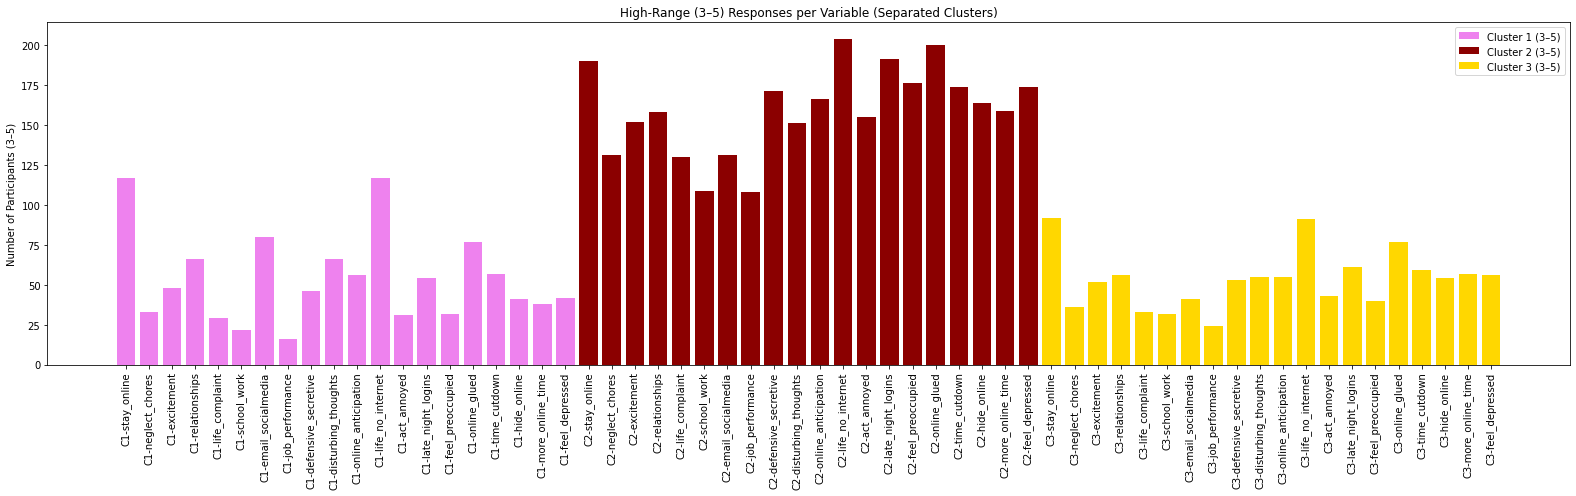

In [9]:
#=================================================================================
# === Pemisahan berdasarkan nilai kelompok ordinal terbesar (3-5) ===

# Count high-range (3,4,5) for each variable per cluster
high_cluster1 = []
high_cluster2 = []
high_cluster3 = []

for var in original_vars:
    high_cluster1.append(
        clustered_data[clustered_data["Cluster"] == 1][var].isin([3, 4, 5]).sum()
    )
    high_cluster2.append(
        clustered_data[clustered_data["Cluster"] == 2][var].isin([3, 4, 5]).sum()
    )
    high_cluster3.append(
        clustered_data[clustered_data["Cluster"] == 3][var].isin([3, 4, 5]).sum()
    )

# X positions: 40 total bars → 20 cluster 1, then 20 cluster 2
x1 = np.arange(20)
x2 = np.arange(20, 40)
x3 = np.arange(40, 60)

plt.figure(figsize=(22, 7))

# Plot cluster 1 bars (violet)
plt.bar(
    x1,
    high_cluster1,
    color="violet",
    label="Cluster 1 (3–5)"
)

# Plot cluster 2 bars (dark red)
plt.bar(
    x2,
    high_cluster2,
    color="darkred",
    label="Cluster 2 (3–5)"
)
# Plot cluster 3 bars (gold)
plt.bar(
    x3,
    high_cluster3,
    color="gold",
    label="Cluster 3 (3–5)"
)
# X-axis labels
combined_labels = (
    [f"C1-{var}" for var in original_vars] +
    [f"C2-{var}" for var in original_vars] +
    [f"C3-{var}" for var in original_vars]
)

plt.xticks(np.arange(60), combined_labels, rotation=90)

plt.ylabel("Number of Participants (3–5)")
plt.title("High-Range (3–5) Responses per Variable (Separated Clusters)")
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
#=================================================================================
# === Combined Table: High-Range (3–5) Responses per Variable and Cluster ===

df_high_combined = pd.DataFrame({
    "IAT Variable": original_vars,
    "Cluster 1 (3–5)": high_cluster1,
    "Cluster 2 (3–5)": high_cluster2,
    "Cluster 3 (3–5)": high_cluster3
})

print("\n=== High-Range (3–5) Responses per IAT Variable and Cluster ===")
print(df_high_combined)



=== High-Range (3–5) Responses per IAT Variable and Cluster ===
           IAT Variable  Cluster 1 (3–5)  Cluster 2 (3–5)  Cluster 3 (3–5)
0           stay_online              117              190               92
1        neglect_chores               33              131               36
2            excitement               48              152               52
3         relationships               66              158               56
4        life_complaint               29              130               33
5           school_work               22              109               32
6     email_socialmedia               80              131               41
7       job_performance               16              108               24
8   defensive_secretive               46              171               53
9   disturbing_thoughts               66              151               55
10  online_anticipation               56              166               55
11     life_no_internet            


Membuat grafik jumlah responden ordinal (0–5) per cluster (side-by-side)...


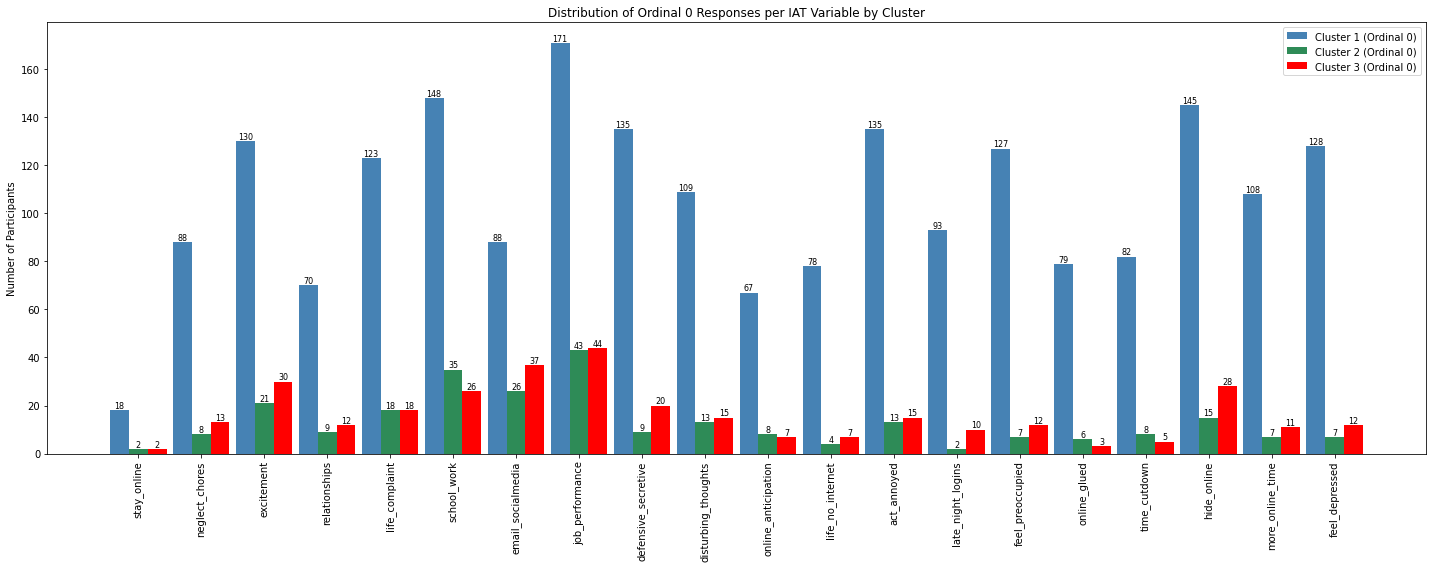

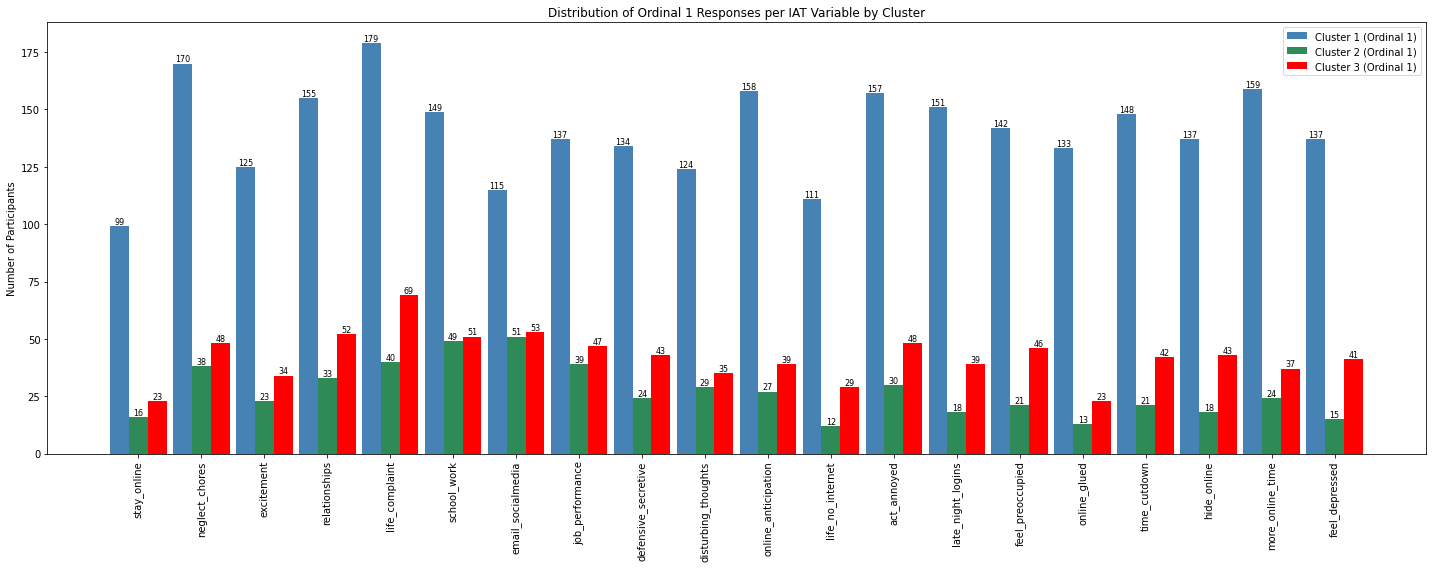

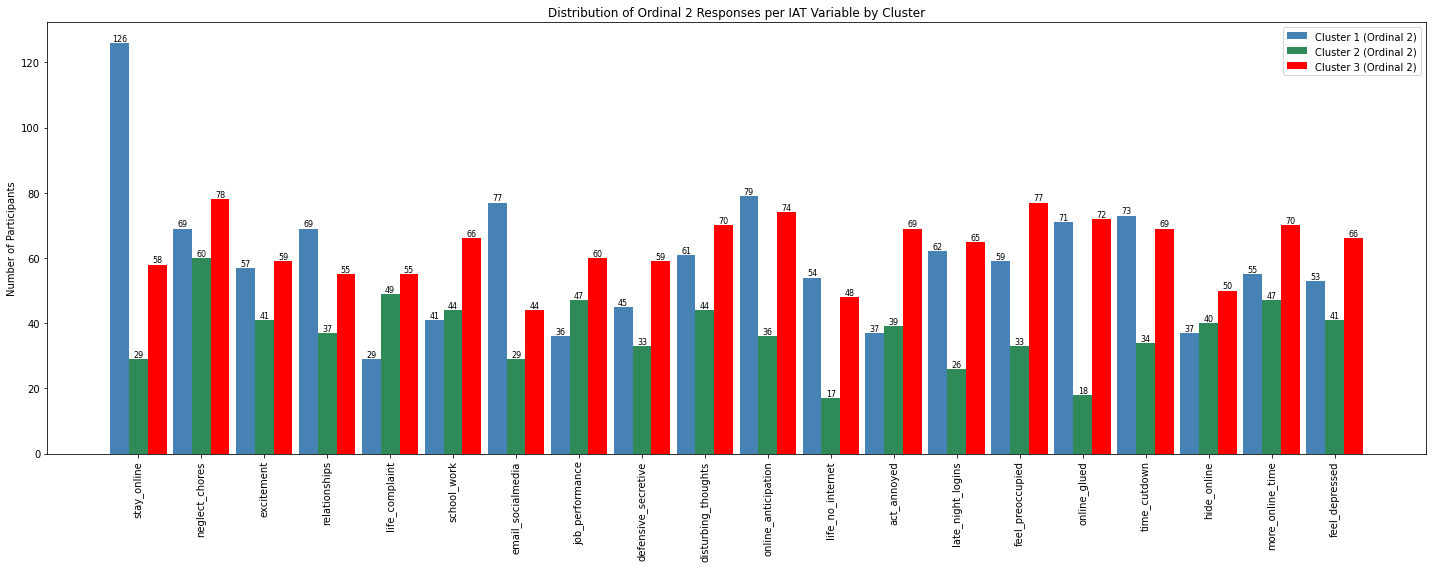

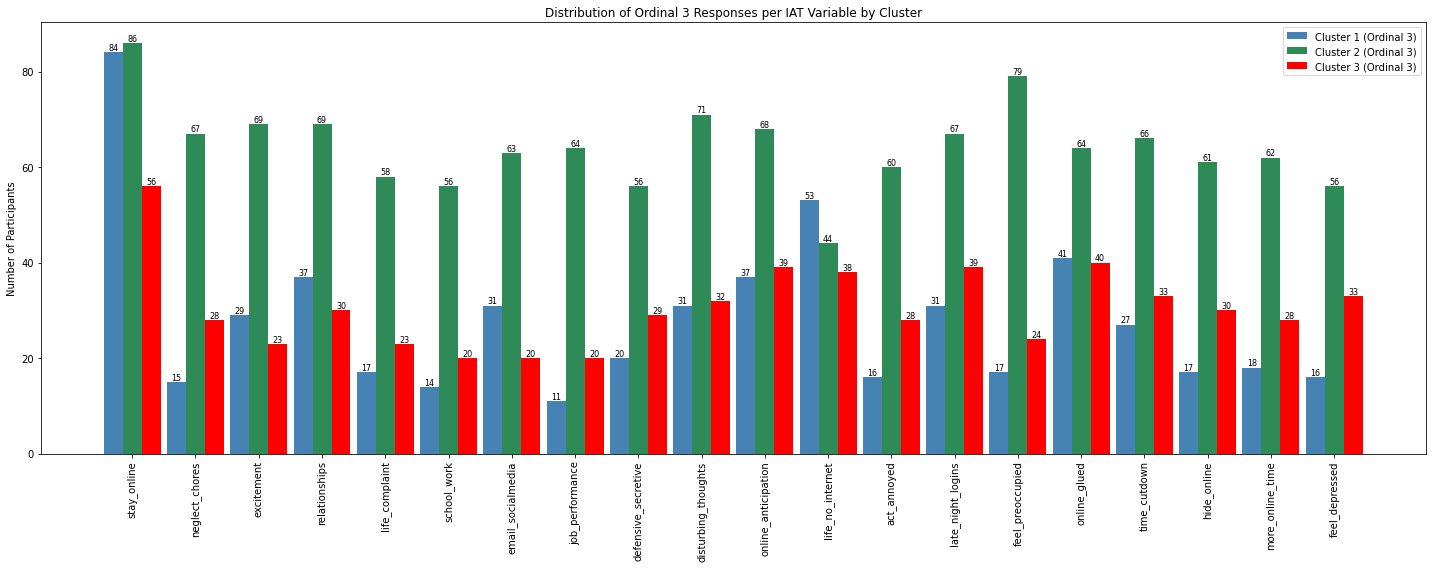

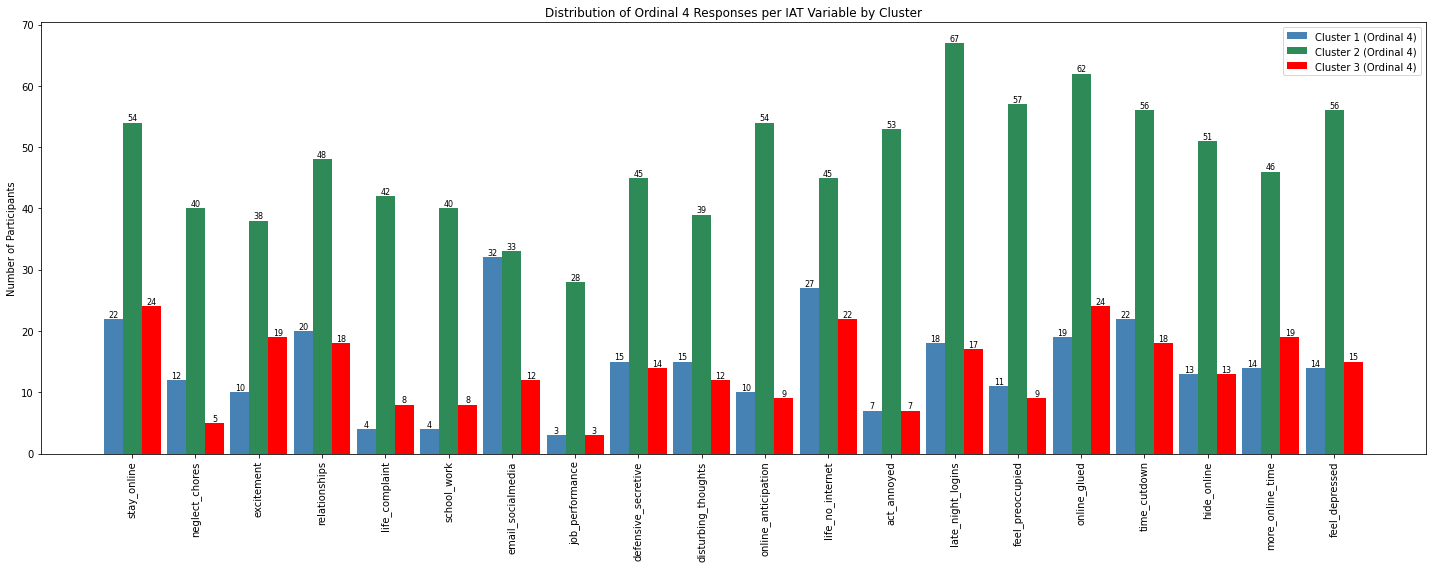

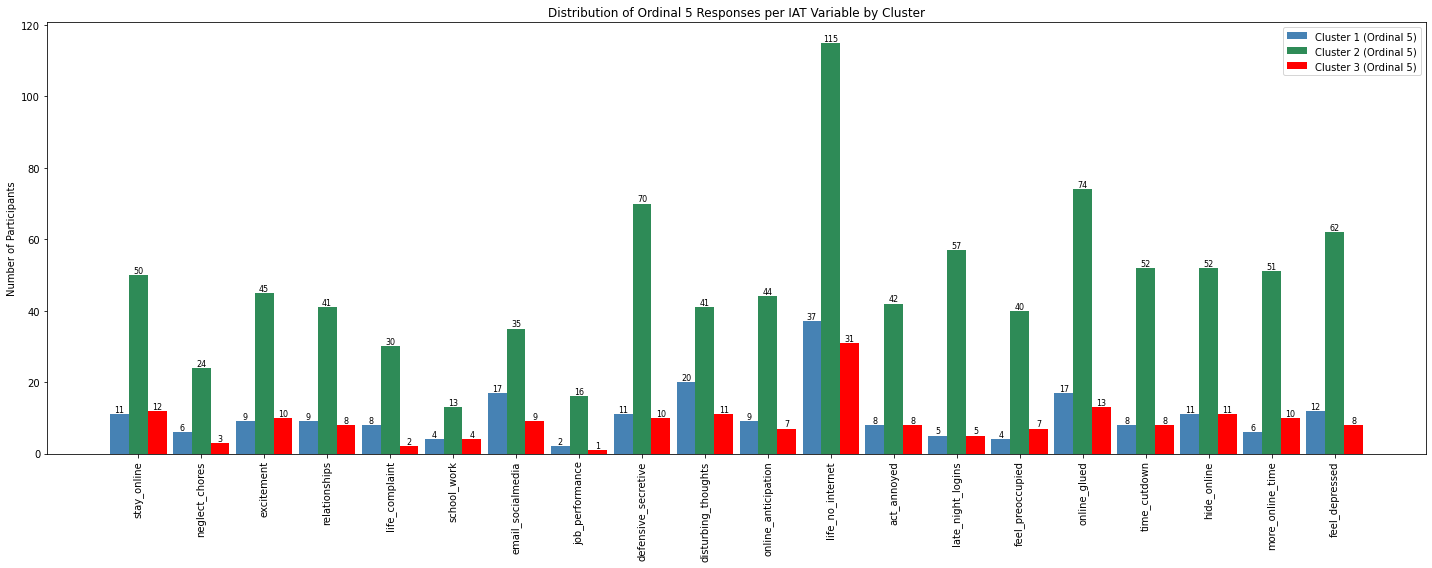

In [18]:
#=================================================================================
# === Ordinal-Level Count Distribution (0–5) ===
# === Side-by-side bars per variable | k = 3 ===

print("\nMembuat grafik jumlah responden ordinal (0–5) per cluster (side-by-side)...")

# ---- DATA PER CLUSTER ----
c1_data = clustered_data[clustered_data["Cluster"] == 1]
c2_data = clustered_data[clustered_data["Cluster"] == 2]
c3_data = clustered_data[clustered_data["Cluster"] == 3]

# ---- BAR SETTINGS ----
x = np.arange(len(original_vars))
width = 0.30   # safe width for k = 3

for ord_val in range(6):

    count_c1 = []
    count_c2 = []
    count_c3 = []

    # ---- COUNT PARTICIPANTS ----
    for var in original_vars:
        count_c1.append(c1_data[var].eq(ord_val).sum())
        count_c2.append(c2_data[var].eq(ord_val).sum())
        count_c3.append(c3_data[var].eq(ord_val).sum())

    plt.figure(figsize=(20, 8))

    bars1 = plt.bar(
        x - width, count_c1, width,
        color="steelblue",
        label=f"Cluster 1 (Ordinal {ord_val})"
    )

    bars2 = plt.bar(
        x, count_c2, width,
        color="seagreen",
        label=f"Cluster 2 (Ordinal {ord_val})"
    )

    bars3 = plt.bar(
        x + width, count_c3, width,
        color="red",
        label=f"Cluster 3 (Ordinal {ord_val})"
    )

    # ---- ADD COUNT LABELS ----
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            h = bar.get_height()
            if h > 0:
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    h,
                    f"{int(h)}",
                    ha="center",
                    va="bottom",
                    fontsize=8
                )

    # ---- AXES ----
    plt.xticks(x, original_vars, rotation=90)
    plt.ylabel("Number of Participants")
    plt.title(f"Distribution of Ordinal {ord_val} Responses per IAT Variable by Cluster")
    plt.legend()

    plt.tight_layout()
    plt.show()
